In [1]:
from blind_walking.envs import locomotion_gym_config, locomotion_gym_env
from blind_walking.envs.env_modifiers import heightfield, stairs, train_course
from blind_walking.envs.env_wrappers import observation_dictionary_split_by_encoder_wrapper as obs_split_wrapper
from blind_walking.envs.env_wrappers import observation_dictionary_to_array_wrapper as obs_array_wrapper
from blind_walking.envs.env_wrappers import simple_openloop, trajectory_generator_wrapper_env
from blind_walking.envs.sensors import cpg_sensors, environment_sensors, robot_sensors, sensor_wrappers
from blind_walking.envs.tasks import forward_task, forward_task_pos, imitation_task
from blind_walking.envs.utilities.controllable_env_randomizer_from_config import ControllableEnvRandomizerFromConfig
from blind_walking.robots import a1, laikago, robot_config

def build_regular_env(
    robot_class,
    motor_control_mode,
    enable_rendering=False,
    on_rack=False,
    action_limit=(0.75, 0.75, 0.75),
    wrap_trajectory_generator=True,
    robot_sensor_list=None,
    env_sensor_list=None,
    env_randomizer_list=None,
    env_modifier_list=None,
    task=None,
    obs_wrapper=None,
    # CPG sensor kwargs
    **kwargs,
):

    sim_params = locomotion_gym_config.SimulationParameters()
    sim_params.enable_rendering = enable_rendering
    sim_params.motor_control_mode = motor_control_mode
    sim_params.reset_time = 2
    sim_params.num_action_repeat = 30
    sim_params.enable_action_interpolation = False
    sim_params.enable_action_filter = True
    sim_params.enable_clip_motor_commands = True
    sim_params.robot_on_rack = on_rack

    gym_config = locomotion_gym_config.LocomotionGymConfig(simulation_parameters=sim_params)

    if robot_sensor_list is None:
        robot_sensor_list = [
            sensor_wrappers.HistoricSensorWrapper(
                robot_sensors.IMUSensor(channels=["R", "P", "dR", "dP", "dY"]), num_history=3
            ),
            sensor_wrappers.HistoricSensorWrapper(robot_sensors.MotorAngleSensor(num_motors=a1.NUM_MOTORS), num_history=3),
            environment_sensors.ForwardTargetPositionSensor(max_distance=0.02),
        ]

    if env_randomizer_list is None:
        # env_randomizer_list = [ControllableEnvRandomizerFromConfig("train_params", step_sample_prob=0.004)]
        env_randomizer_list = []

    if env_modifier_list is None:
        env_modifier_list = []

    if task is None:
        task = forward_task_pos.ForwardTask()

    if obs_wrapper is None:
        obs_wrapper = obs_array_wrapper.ObservationDictionaryToArrayWrapper

    env = locomotion_gym_env.LocomotionGymEnv(
        gym_config=gym_config,
        robot_class=robot_class,
        robot_sensors=robot_sensor_list,
        env_sensors=env_sensor_list,
        task=task,
        env_randomizers=env_randomizer_list,
        env_modifiers=env_modifier_list,
    )

    env = obs_wrapper(env)
    if (motor_control_mode == robot_config.MotorControlMode.POSITION) and wrap_trajectory_generator:
        if robot_class == laikago.Laikago:
            env = trajectory_generator_wrapper_env.TrajectoryGeneratorWrapperEnv(
                env,
                trajectory_generator=simple_openloop.LaikagoPoseOffsetGenerator(action_limit=action_limit),
            )
        elif robot_class == a1.A1:
            env = trajectory_generator_wrapper_env.TrajectoryGeneratorWrapperEnv(
                env,
                trajectory_generator=simple_openloop.LaikagoPoseOffsetGenerator(action_limit=action_limit),
            )
    return env

pybullet build time: Jan 19 2022 23:07:37


In [16]:
# Check order of history sensor

import gym 
import utils.import_envs

env = gym.make("A1GymEnv-v0")
reset_obs = env.reset()
imu_history_sensor = env.all_sensors()[0]
motor_angle_history_sensor = env.all_sensors()[1]

print(imu_history_sensor.get_observation())
print(motor_angle_history_sensor.get_observation())
print(reset_obs)

obs = env.step(env.action_space.sample())
print(imu_history_sensor.get_observation())
print(motor_angle_history_sensor.get_observation())
print(obs)


argv[0]=
[ 0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.]
[ 0.   0.9 -1.8  0.   0.9 -1.8  0.   0.9 -1.8  0.   0.9 -1.8  0.   0.9
 -1.8  0.   0.9 -1.8  0.   0.9 -1.8  0.   0.9 -1.8  0.   0.9 -1.8  0.
  0.9 -1.8  0.   0.9 -1.8  0.   0.9 -1.8]
[ 0.   -0.    0.    0.    0.    0.   -0.    0.    0.    0.    0.   -0.
  0.    0.    0.    0.    0.9  -1.8   0.    0.9  -1.8   0.    0.9  -1.8
  0.    0.9  -1.8   0.    0.9  -1.8   0.    0.9  -1.8   0.    0.9  -1.8
  0.    0.9  -1.8   0.    0.9  -1.8   0.    0.9  -1.8   0.    0.9  -1.8
  0.    0.9  -1.8   0.02  0.  ]
[-0.00324656  0.00352601  0.01530273  0.02137251 -0.00991254  0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.        ]
[-0.00868369  0.84978019 -1.74305191  0.0515954   0.85103049 -1.79307602
 -0.06400202  0.88591367 -1.68785803  0.04484758  0.82190147 -1.7084004
  0.          0.9        -1.8         0.          0.9        -1.8
  0.          0.9        -1.8         0.        

/home/daniel/anaconda3/envs/rl-baselines-zoo-cu113/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


[-4.33959951e-10  3.28005845e-10  5.99035424e-09  1.36387902e-08
  2.44270829e-09 -1.59867768e-09  4.05565970e-10 -3.08080703e-09
 -7.69610153e-10  3.22392008e-09  6.99859004e-10  1.50328505e-09
 -2.84036453e-09  6.25259067e-10 -2.03998116e-09 -2.39605980e-09
  8.99999976e-01 -1.79999995e+00  6.84868234e-09  8.99999980e-01
 -1.79999994e+00 -2.63591174e-09  8.99999971e-01 -1.79999997e+00
 -1.06169411e-09  8.99999978e-01 -1.79999997e+00 -1.14337140e-09
  8.99999977e-01 -1.79999996e+00 -5.95462124e-09  8.99999970e-01
 -1.79999996e+00  2.08226052e-09  8.99999975e-01 -1.79999992e+00
 -2.65358707e-10  8.99999976e-01 -1.79999996e+00  6.45146475e-09
  8.99999977e-01 -1.79999996e+00 -1.16385570e-08  8.99999982e-01
 -1.79999996e+00  1.88159216e-09  8.99999977e-01 -1.79999995e+00
 -3.06742846e-10  8.99999977e-01 -1.79999995e+00  1.99999995e-02
  1.37684321e-11]
1.8263088022784297e-07


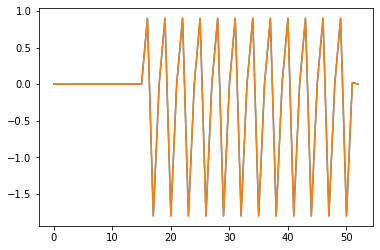

In [20]:
# Check that normalization works as expected

import numpy as np

model_dir = "/home/daniel/Documents/github/mcx-lab/rl-baselines3-zoo/logs/minimal-locomotion/ppo/A1GymEnv-v0_5"
parameters_dir = model_dir + "/parameters"

nn_obs = np.loadtxt(parameters_dir + "/nn_observations.csv", delimiter=',')
obs_mean = np.loadtxt(parameters_dir + "/obs_mean.csv", delimiter=',')
obs_std = np.loadtxt(parameters_dir + "/obs_std.csv", delimiter=',')

unnormalized_obs = nn_obs * obs_std + obs_mean
print(unnormalized_obs[0])
print(np.linalg.norm(reset_obs - unnormalized_obs[0]))

index = np.arange(53)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(index, unnormalized_obs[0])
ax.plot(index, reset_obs)

2.0076120502297092
11.961975210685653


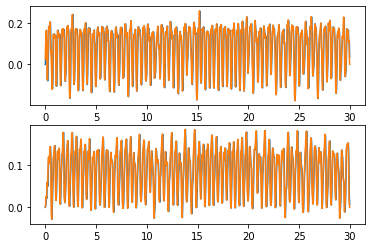

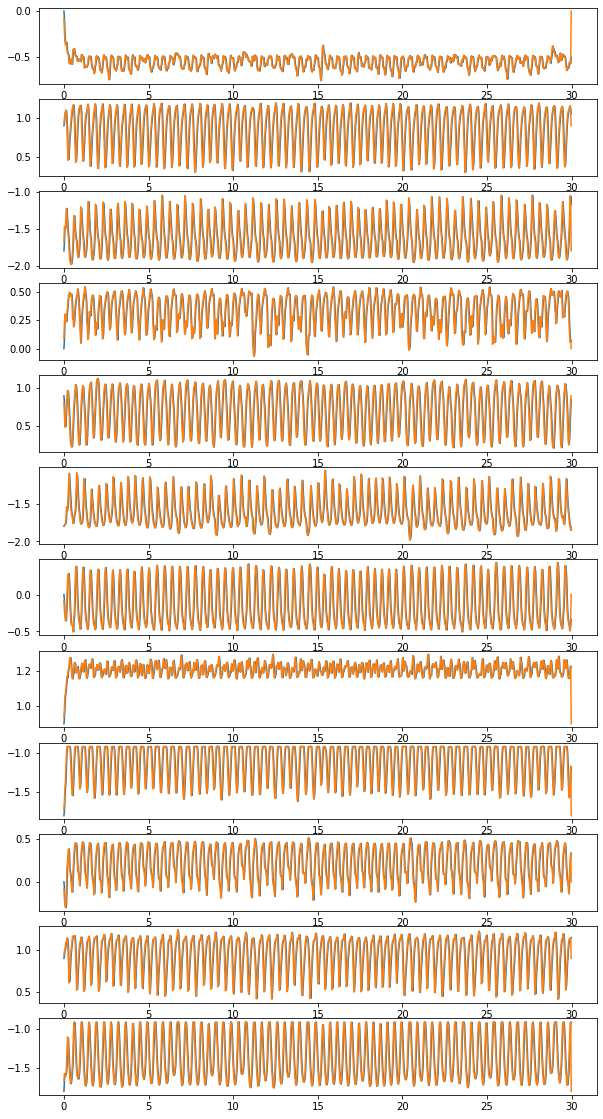

In [29]:
# Compare the sensor values obtained from env.step
# to the sensor values obtained directly from the A1 robot class

import numpy as np

model_dir = "/home/daniel/Documents/github/mcx-lab/rl-baselines3-zoo/logs/minimal-locomotion/ppo/A1GymEnv-v0_5"
parameters_dir = model_dir + "/parameters"

nn_obs = np.loadtxt(parameters_dir + "/nn_observations.csv", delimiter=',')
obs_mean = np.loadtxt(parameters_dir + "/obs_mean.csv", delimiter=',')
obs_std = np.loadtxt(parameters_dir + "/obs_std.csv", delimiter=',')
unnormalized_obs = nn_obs * obs_std + obs_mean

env_imu_obs = unnormalized_obs[:,:2]
direct_imu_obs = np.loadtxt(parameters_dir + "/baseRpy.csv", delimiter=',')[:,:2]

env_motor_angle_obs = unnormalized_obs[:,15:27]
direct_motor_angle_obs = np.loadtxt(parameters_dir + "/motorPosition.csv", delimiter=',') 

print(np.linalg.norm(env_imu_obs - direct_imu_obs))
print(np.linalg.norm(env_motor_angle_obs - direct_motor_angle_obs))
index = np.arange(1000) * 0.03

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)
for i in range(2):
    ax[i].plot(index, env_imu_obs[:,i])
    ax[i].plot(index, direct_imu_obs[:,i])

fig, ax = plt.subplots(12, figsize=(10, 20))
for i in range(12):
    ax[i].plot(index, env_motor_angle_obs[:,i])
    ax[i].plot(index, direct_motor_angle_obs[:,i])

# Conclusion. It is okay to use the direct A1 robot class methods